## Projet 2 : Classification de cartes de jeu

##### © Jessim Ahdjoudj

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import timm
from tqdm.notebook import tqdm
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

<b> 1) Définition du Dataset et du Dataloader </b>

Création Dataset

In [6]:
class PlayingCardDataset(Dataset):
    def __init__(self, data_dir, transform = None):
        self.data = ImageFolder(data_dir, transform = transform)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    @property
    def classes(self):
        return self.data.classes

In [7]:
dataset = PlayingCardDataset(data_dir = 'c:\\Users\\Dr House\\Desktop\\Data Science Repertory\\Portfolio\\Card Classifier')

Checks

In [8]:
# Check dataset est correctement crée : comparer exemple au dictonnaire des labels et leur numéro associé
data_dir = 'c:\\Users\\Dr House\\Desktop\\Data Science Repertory\\Portfolio\\Card Classifier\\Data\\train'
numlabels = {v: k for k, v in ImageFolder(data_dir).class_to_idx.items()}
print(numlabels)

{0: 'ace of clubs', 1: 'ace of diamonds', 2: 'ace of hearts', 3: 'ace of spades', 4: 'eight of clubs', 5: 'eight of diamonds', 6: 'eight of hearts', 7: 'eight of spades', 8: 'five of clubs', 9: 'five of diamonds', 10: 'five of hearts', 11: 'five of spades', 12: 'four of clubs', 13: 'four of diamonds', 14: 'four of hearts', 15: 'four of spades', 16: 'jack of clubs', 17: 'jack of diamonds', 18: 'jack of hearts', 19: 'jack of spades', 20: 'joker', 21: 'king of clubs', 22: 'king of diamonds', 23: 'king of hearts', 24: 'king of spades', 25: 'nine of clubs', 26: 'nine of diamonds', 27: 'nine of hearts', 28: 'nine of spades', 29: 'queen of clubs', 30: 'queen of diamonds', 31: 'queen of hearts', 32: 'queen of spades', 33: 'seven of clubs', 34: 'seven of diamonds', 35: 'seven of hearts', 36: 'seven of spades', 37: 'six of clubs', 38: 'six of diamonds', 39: 'six of hearts', 40: 'six of spades', 41: 'ten of clubs', 42: 'ten of diamonds', 43: 'ten of hearts', 44: 'ten of spades', 45: 'three of clu

0


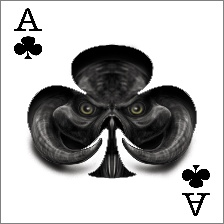

In [9]:
image, label = dataset[0]
print(label)
image

In [10]:
# Check dataset est correctement crée (taille vs taille csv)
len(dataset)

8154

In [11]:
# Redimentionner toutes les images à la même taile (128x128) puis convertion en tensor PyTorch
data_dir = 'c:\\Users\\Dr House\\Desktop\\Data Science Repertory\\Portfolio\\Card Classifier\\Data\\train'
transform = transforms.Compose([transforms.Resize((128, 128)),transforms.ToTensor(),])
dataset = PlayingCardDataset(data_dir, transform)

Création Dataloader

In [12]:
dataloader = DataLoader(dataset, batch_size = 32, shuffle = True)

<b> 2) Création du modèle</b>

In [13]:
class CNNCardClassifer(nn.Module):
    def __init__(self, num_classes = 53): # pour le nombre de carte, i.e. 52
        super(CNNCardClassifer, self).__init__()
        self.base_model = timm.create_model('efficientnet_b0', pretrained = True)
        self.features = nn.Sequential(*list(self.base_model.children())[:-1])
        enet_out_size = 1280
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(enet_out_size, num_classes)
        )
    
    def forward(self, x):
        x = self.features(x)
        output = self.classifier(x)
        return output

<b> 3) Entrainement du modèle</b>

Création des Datasets d'entrainement, de validation et de test

In [14]:
transform = transforms.Compose([transforms.Resize((128, 128)),transforms.ToTensor(),])

# Entrainement
train_folder = 'c:\\Users\\Dr House\\Desktop\\Data Science Repertory\\Portfolio\\Card Classifier\\Data\\train'
train_dataset = PlayingCardDataset(train_folder, transform = transform)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)

# Validation
valid_folder = 'c:\\Users\\Dr House\\Desktop\\Data Science Repertory\\Portfolio\\Card Classifier\\Data\\valid'
val_dataset = PlayingCardDataset(valid_folder, transform = transform)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

# Test
test_folder = 'c:\\Users\\Dr House\\Desktop\\Data Science Repertory\\Portfolio\\Card Classifier\\Data\\test'
test_dataset = PlayingCardDataset(test_folder, transform = transform)
test_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

Création de la boucle d'entrainement

In [15]:
num_epochs = 5

train_losses, val_losses = [], []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = CNNCardClassifer(num_classes = 53)
model.to(device)

loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

for epoch in range(num_epochs):
    # Phase d'entrainement
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc = 'Entrainement'):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
    train_loss = running_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Phase de validation
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc = 'Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_function(outputs, labels)
            running_loss += loss.item() * labels.size(0)
    val_loss = running_loss / len(val_loader.dataset)
    val_losses.append(val_loss)

    # Epoch stats
    print(f"Epoch {epoch+1}/{num_epochs} - Entrainement loss: {train_loss}, Validation loss: {val_loss}")

Entrainement:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 1/5 - Entrainement loss: 1.5815924028284527, Validation loss: 0.37467086899955315


Entrainement:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2/5 - Entrainement loss: 0.5662984428976165, Validation loss: 0.21694956351563616


Entrainement:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3/5 - Entrainement loss: 0.3319494248155782, Validation loss: 0.1693783628490736


Entrainement:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4/5 - Entrainement loss: 0.22692455277081428, Validation loss: 0.1715601882563447


Entrainement:   0%|          | 0/239 [00:00<?, ?it/s]

Validation:   0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5/5 - Entrainement loss: 0.2143010982319103, Validation loss: 0.1345077707520071


Visualisation des pertes (loss function)

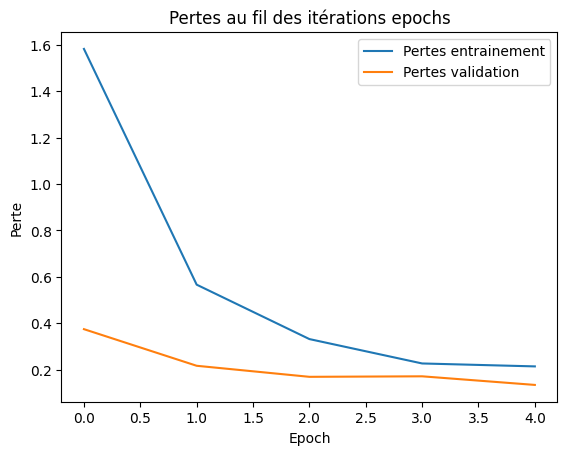

In [16]:
plt.plot(train_losses, label = 'Pertes entrainement')
plt.plot(val_losses, label = 'Pertes validation')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.title("Pertes au fil des itérations epochs")
plt.show()

<b> 4) Evaluation des résultats de l'apprentisage </b>

Création prédiction du modèle

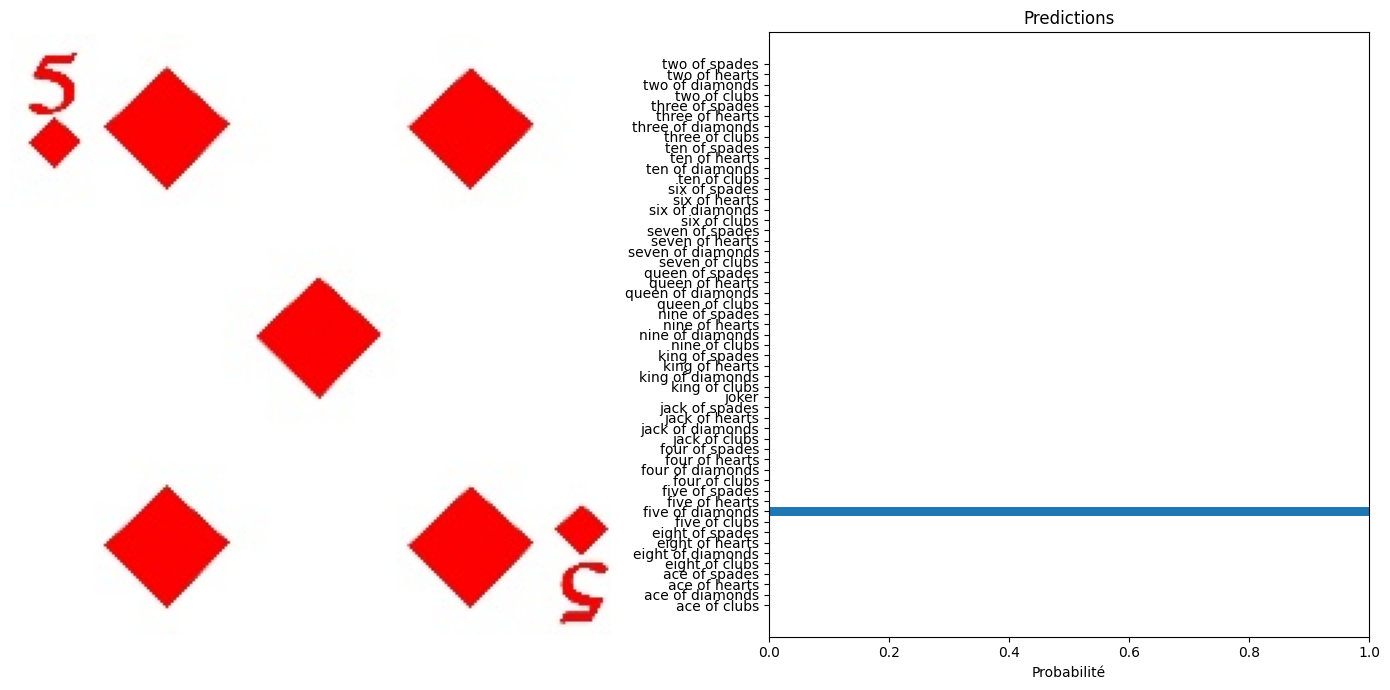

In [19]:
# Chargement et traitement de l'image
def preprocess_image(image_path, transform):
    image = Image.open(image_path).convert("RGB")
    return image, transform(image).unsqueeze(0)

# Prédiction du modèle
def predict(model, image_tensor, device):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim = 1)
    return probabilities.cpu().numpy().flatten()

# Visualisation des prédictions (carte à gauche, prédiction à droite)
def visualize_predictions(original_image, probabilities, class_names):
    fig, axarr = plt.subplots(1, 2, figsize = (14, 7))
    axarr[0].imshow(original_image)
    axarr[0].axis("off")
    axarr[1].barh(class_names, probabilities)
    axarr[1].set_xlabel("Probabilité")
    axarr[1].set_title("Predictions")
    axarr[1].set_xlim(0, 1)
    plt.tight_layout()
    plt.show()

# Check fonctionnement prédiction
test_image = "c:\\Users\\Dr House\\Desktop\\Data Science Repertory\\Portfolio\\Card Classifier\\Data\\test\\five of diamonds\\2.jpg"
transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])

original_image, image_tensor = preprocess_image(test_image, transform)
probabilities = predict(model, image_tensor, device)

class_names = dataset.classes 
visualize_predictions(original_image, probabilities, class_names)

Evalutation du modèle sur le dataset de test

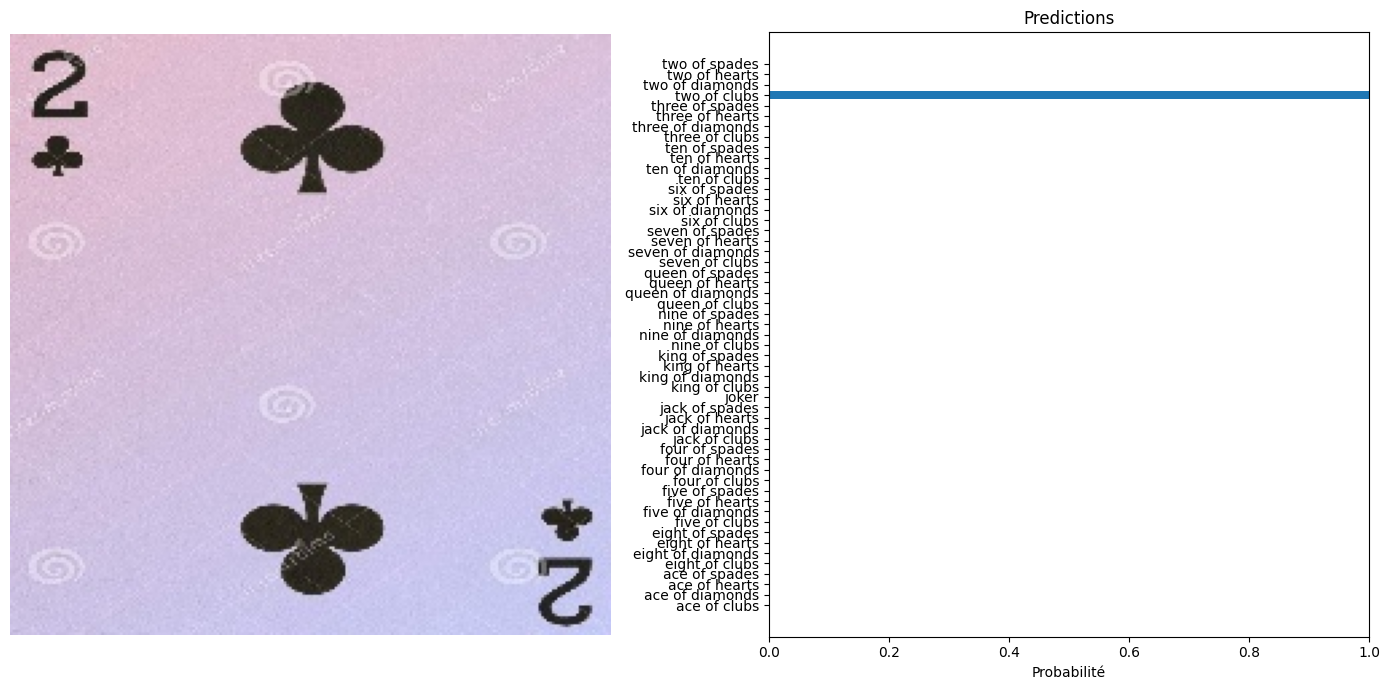

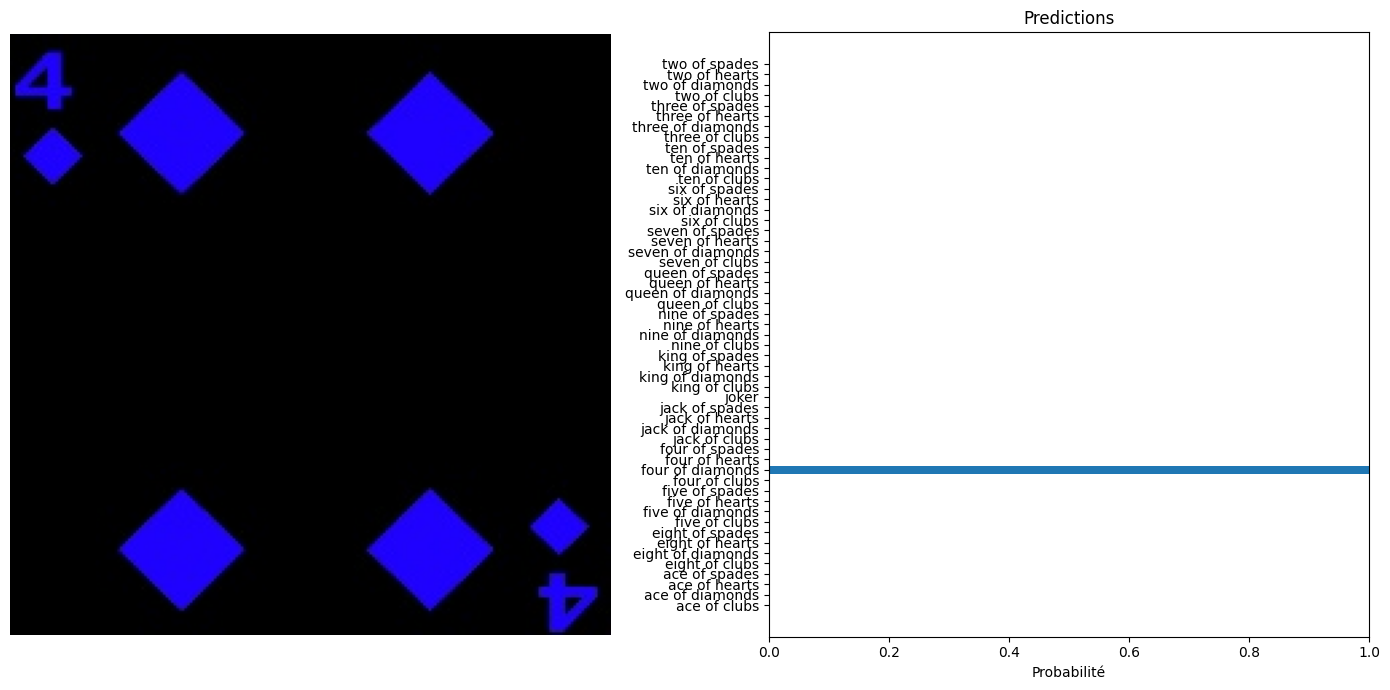

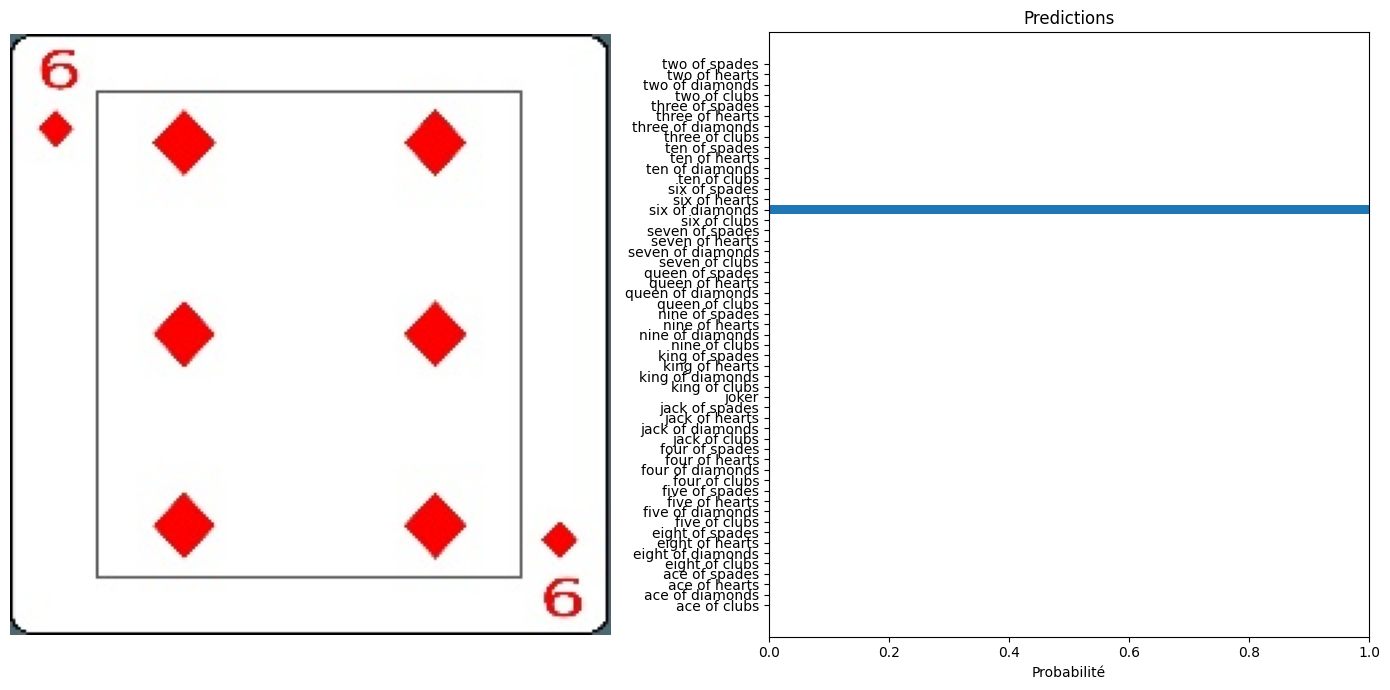

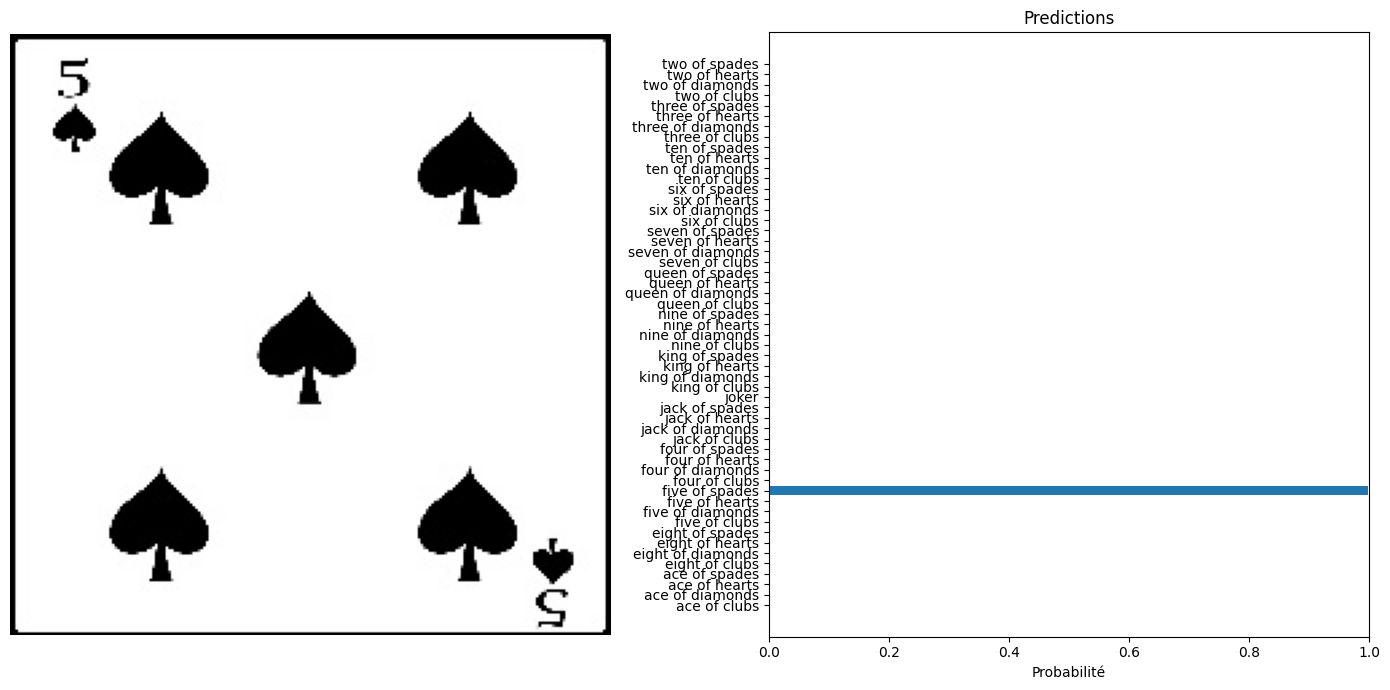

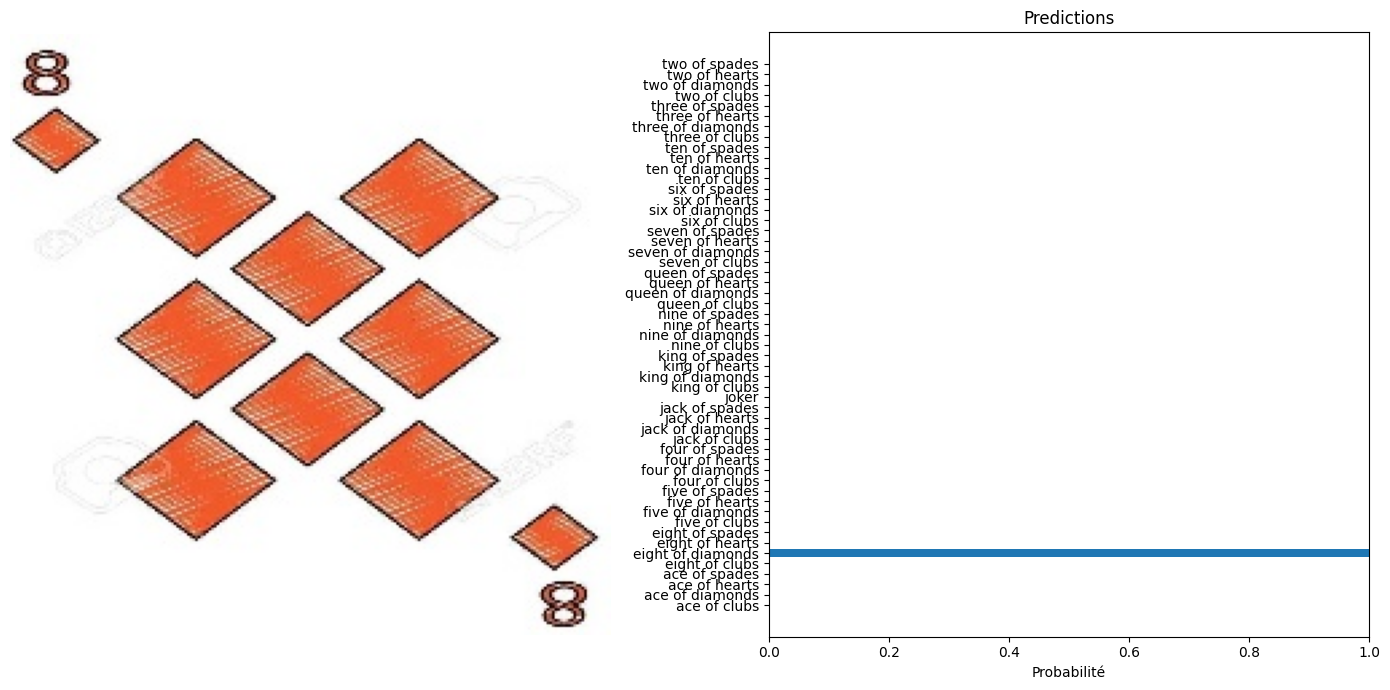

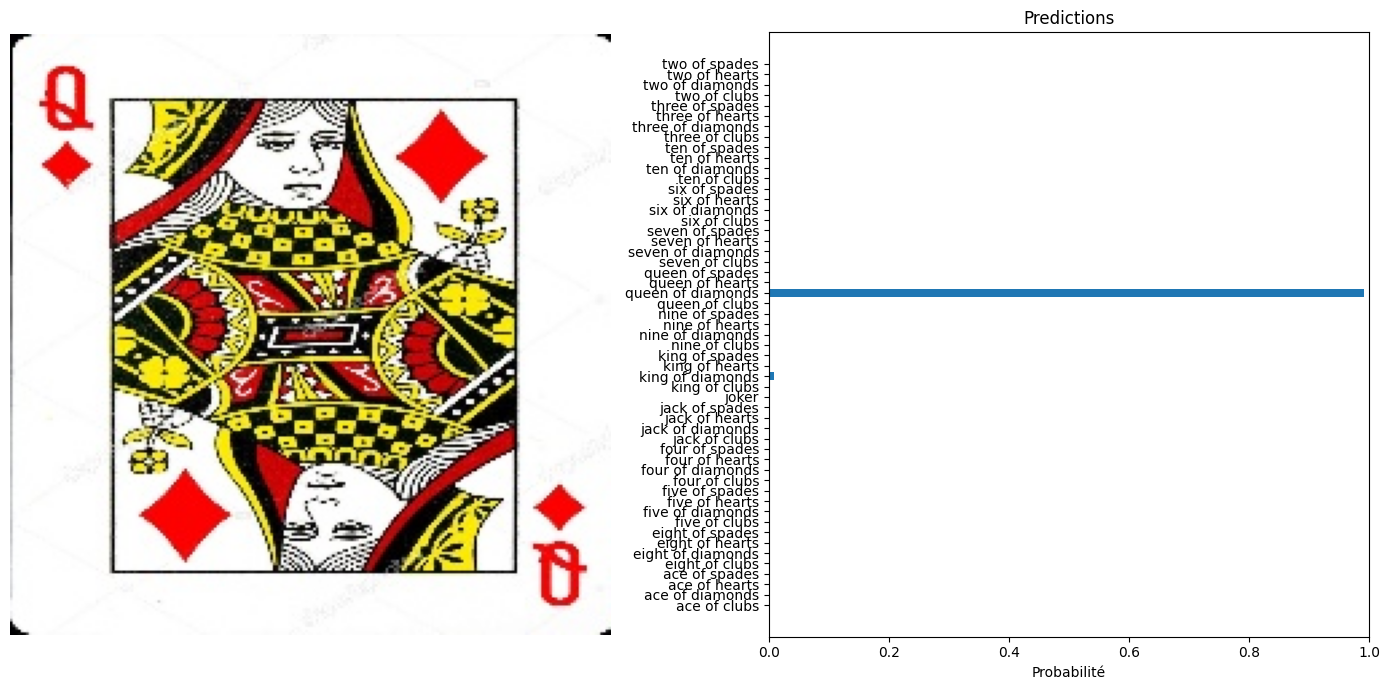

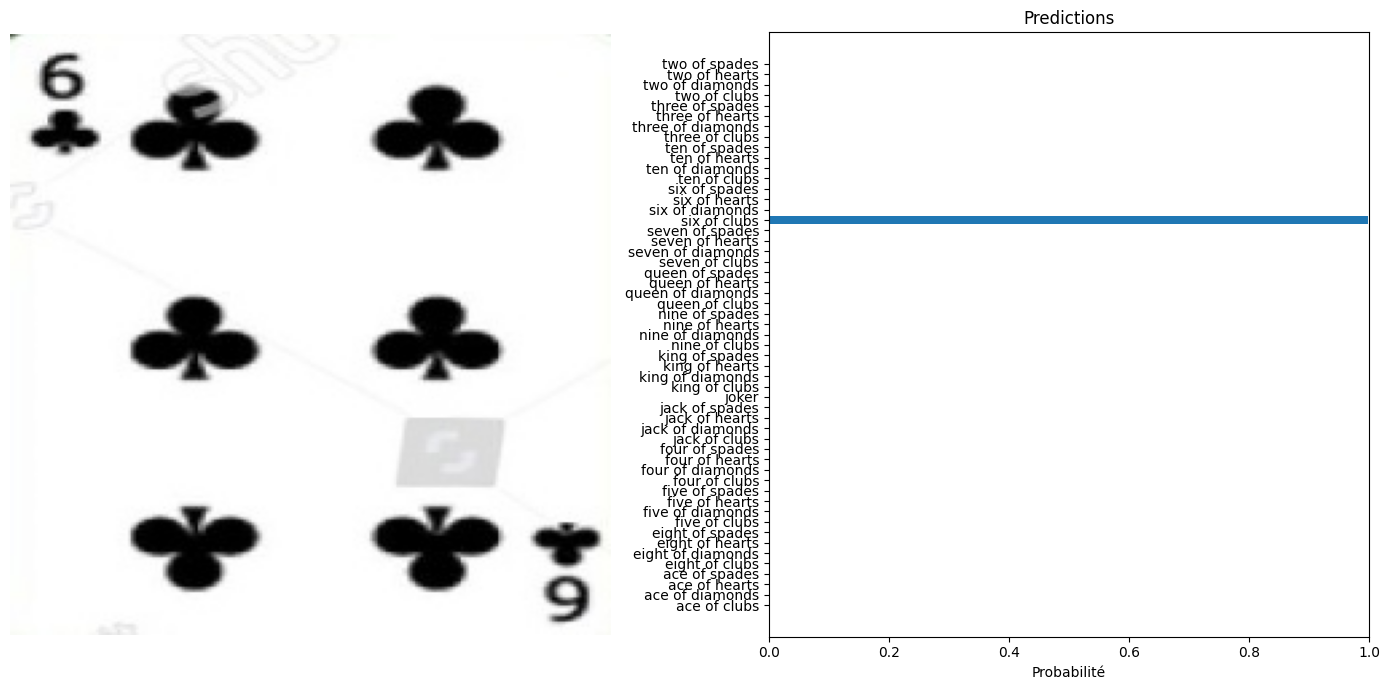

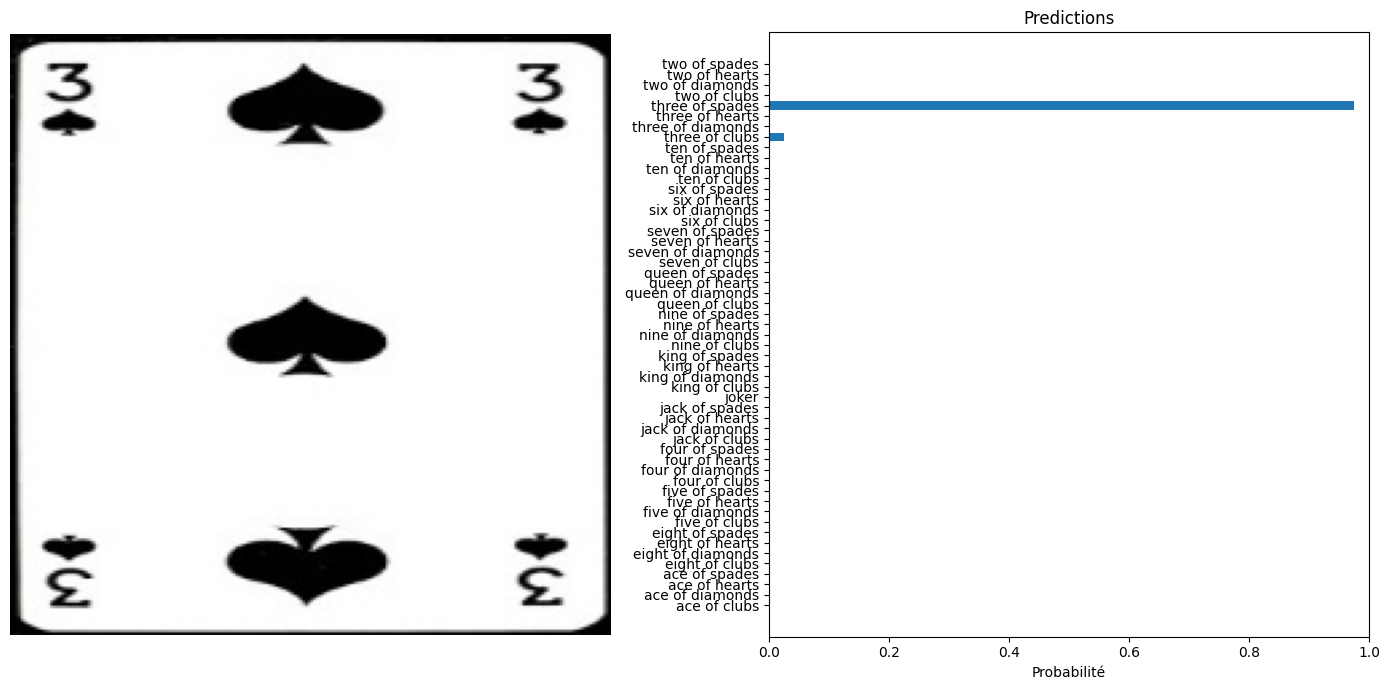

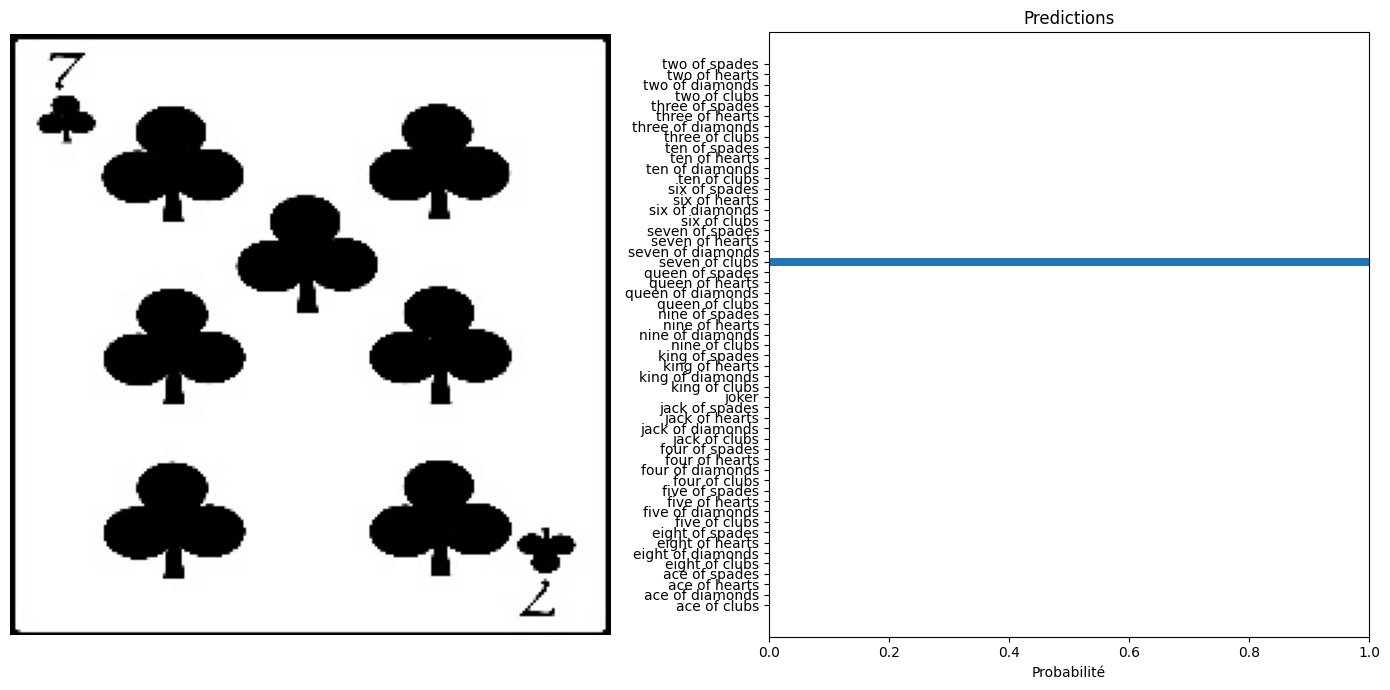

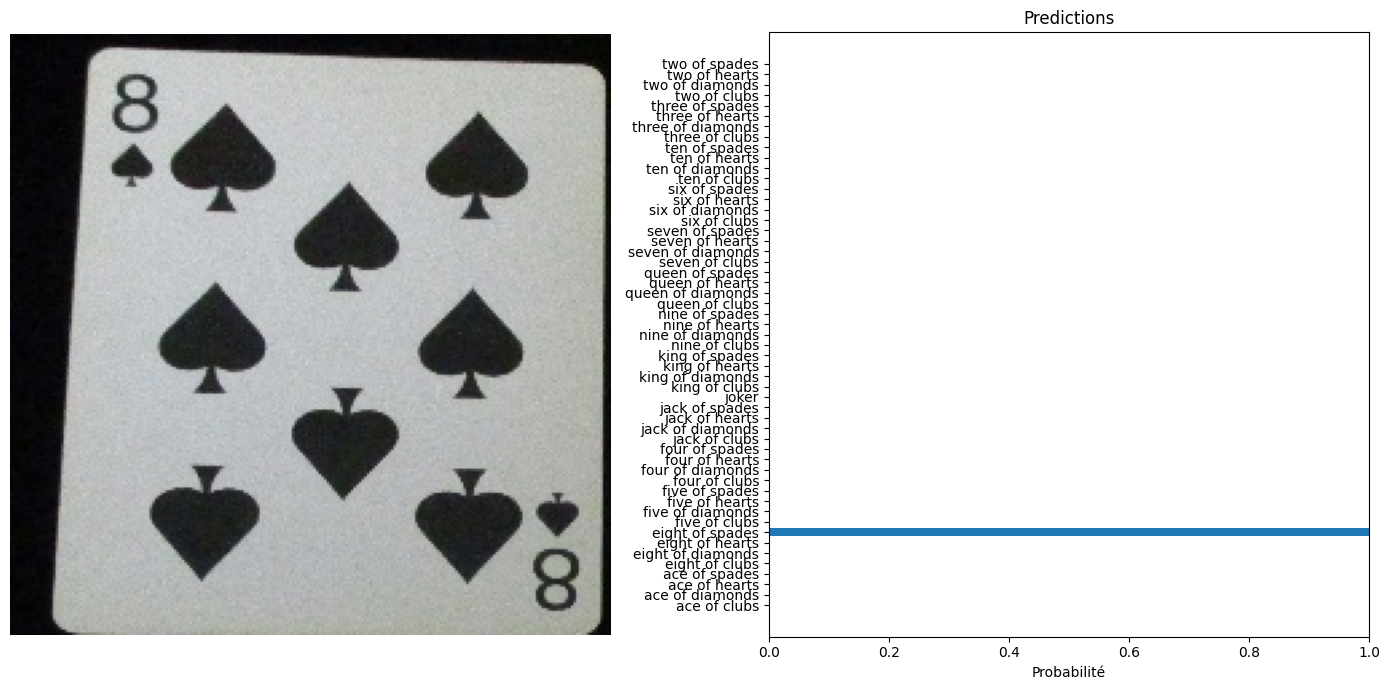

In [20]:
from glob import glob

test_images = glob('c:\\Users\\Dr House\\Desktop\\Data Science Repertory\\Portfolio\\Card Classifier\\Data\\test\\*\\*')
test_exemples = np.random.choice(test_images, 10)

for exemple in test_exemples:
    original_image, image_tensor = preprocess_image(exemple, transform)
    probabilities = predict(model, image_tensor, device)
    class_names = dataset.classes 
    visualize_predictions(original_image, probabilities, class_names)